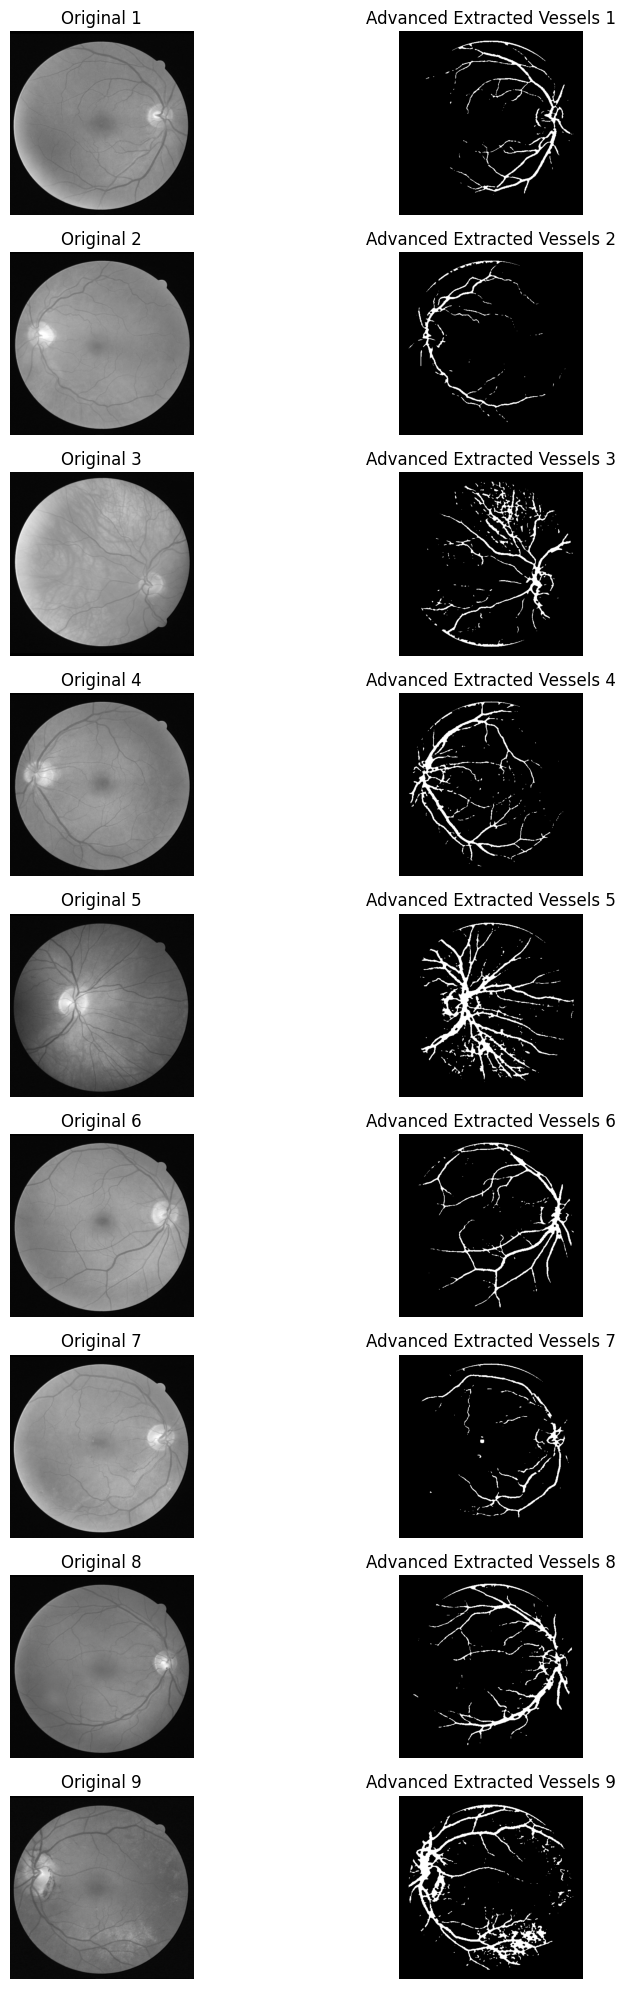

Advanced processed images are saved in 'processed_images1' directory.


In [ ]:
import cv2
import numpy as np
import matplotlib.pyplot as plt
import os
from skimage.filters import frangi
from skimage import morphology
from skimage.morphology import skeletonize

# Define file paths again
image_paths = ["0.png", "1.png", "2.png", "3.png", "4.png", "5.png", "6.png", "7.png", "8.png"]
processed_images = []

# Create output directory if it doesn't exist
output_dir = "processed_images1"
os.makedirs(output_dir, exist_ok=True)

def custom_clahe(image, clip_limit=4, tile_grid_size=(10, 10)):
    """Custom implementation of CLAHE with improved contrast."""
    lab = cv2.cvtColor(image, cv2.COLOR_BGR2LAB)
    l, a, b = cv2.split(lab)
    clahe = cv2.createCLAHE(clipLimit=clip_limit, tileGridSize=tile_grid_size)
    l = clahe.apply(l)
    lab = cv2.merge((l, a, b))
    return cv2.cvtColor(lab, cv2.COLOR_LAB2BGR)[:, :, 1]

def custom_dilate(image, kernel):
    """Custom implementation of dilation."""
    h, w = image.shape
    kh, kw = kernel.shape
    pad_h, pad_w = kh // 2, kw // 2
    padded_image = np.pad(image, ((pad_h, pad_h), (pad_w, pad_w)), mode='constant', constant_values=0)
    result = np.zeros_like(image)

    for i in range(h):
        for j in range(w):
            result[i, j] = np.max(padded_image[i:i+kh, j:j+kw] * kernel)
    return result

def custom_erode(image, kernel):
    """Custom implementation of erosion."""
    h, w = image.shape
    kh, kw = kernel.shape
    pad_h, pad_w = kh // 2, kw // 2
    padded_image = np.pad(image, ((pad_h, pad_h), (pad_w, pad_w)), mode='constant', constant_values=255)
    result = np.zeros_like(image)

    for i in range(h):
        for j in range(w):
            result[i, j] = np.min(padded_image[i:i+kh, j:j+kw] * kernel)
    return result

def custom_morphology_ex(image, kernel_size, operation):
    """Custom implementation of morphological operations with larger kernel sizes."""
    kernel = cv2.getStructuringElement(cv2.MORPH_ELLIPSE, kernel_size)
    result = np.zeros_like(image)

    if operation == "blackhat":
        dilated = custom_dilate(image, kernel)
        result = dilated - image
    elif operation == "close":
        dilated = custom_dilate(image, kernel)
        result = custom_erode(dilated, kernel)

    return result

def custom_otsu_threshold(image):
    """Custom implementation of Otsu's thresholding with Gaussian blur."""
    blurred = cv2.GaussianBlur(image, (5, 5), 0)
    _, thresholded = cv2.threshold(blurred, 0, 255, cv2.THRESH_BINARY + cv2.THRESH_OTSU)
    return thresholded

def refine_vessels(binary_vessels, mask):
    """Refine vessels using a mask, smoothing, and skeletonization."""
    mask = cv2.medianBlur(mask, 5)
    masked_vessels = cv2.bitwise_and(binary_vessels, binary_vessels, mask=mask)
    thin_vessels = skeletonize(masked_vessels > 0).astype(np.uint8) * 255
    return thin_vessels

def combine_vessels(initial_vessels, thin_vessels):
    """Combine the extracted vessels with the refined thin vessels and apply post-processing."""
    combined = cv2.bitwise_or(initial_vessels, thin_vessels)
    kernel = cv2.getStructuringElement(cv2.MORPH_ELLIPSE, (5, 5))
    return cv2.morphologyEx(combined, cv2.MORPH_CLOSE, kernel)

def remove_outer_circle_manual(image):
    """Manually remove the outer circle using center estimation and pixel thresholding."""
    h, w = image.shape[:2]

    center_x, center_y = w // 2, h // 2

    radius = int(min(w, h) * 0.45)

    mask = np.zeros((h, w), dtype=np.uint8)
    for y in range(h):
        for x in range(w):
            distance = np.sqrt((x - center_x) ** 2 + (y - center_y) ** 2)

            if distance <= radius:
                mask[y, x] = 255
    cleaned_image = cv2.bitwise_and(image, mask)

    return cleaned_image

def vessel_extraction_blackhat(image_path, output_path):
    image = cv2.imread(image_path)
    green_channel = custom_clahe(image)

    bottom_hat = custom_morphology_ex(green_channel, (8, 8), "blackhat")
    initial_vessels = custom_otsu_threshold(bottom_hat)

    mask = cv2.inRange(green_channel, 30, 220)
    thin_vessels = refine_vessels(initial_vessels, mask)
    final_vessels = combine_vessels(initial_vessels, thin_vessels)
    cleaned_vessels = remove_outer_circle_manual(final_vessels)

    cv2.imwrite(output_path, cleaned_vessels)
    return cleaned_vessels

advanced_binary_masks = []
for image_file in image_paths:
    output_path = os.path.join(output_dir, os.path.basename(image_file))
    processed_image = vessel_extraction_blackhat(image_file, output_path)
    advanced_binary_masks.append(processed_image)

# Display side-by-side comparison of original and advanced extracted images
fig, axes = plt.subplots(len(image_paths), 2, figsize=(10, 20))

for idx in range(len(image_paths)):
    original = cv2.imread(image_paths[idx], cv2.IMREAD_GRAYSCALE)

    # # Show original image
    axes[idx, 0].imshow(original, cmap='gray')
    axes[idx, 0].set_title(f"Original {idx+1}")
    axes[idx, 0].axis("off")

    # # Show advanced extracted vessels
    axes[idx, 1].imshow(advanced_binary_masks[idx], cmap='gray')
    axes[idx, 1].set_title(f"Advanced Extracted Vessels {idx+1}")
    axes[idx, 1].axis("off")

plt.tight_layout()
plt.show()

print(f"Advanced processed images are saved in '{output_dir}' directory.")


In [ ]:
# Encoding
def rle_encoding(x):
    '''
    x: numpy array of shape (height, width), non 0 - mask, 0 - background
    Returns run length as list
    '''
    run_lengths = []
    for i in range(x.shape[0]*x.shape[1]):
        run_lengths.append([])
    current = 0
    count = 0
    start = 0
    flat = x.T.flatten()
    for i in range(len(flat)):
        dot = flat[i]
        if dot == 0:
            if current == 0:
                continue
            else:
                run_lengths[current-1].extend([start, count])
                current = 0
                count = 0
                start = 0
        else:
            if dot == current:
                count += 1
            elif count != 0:
                run_lengths[current-1].extend([start, count])
                current = 0
                count = 0
                start = 0
            else:
                start = i
                current = dot
                count += 1
    return run_lengths


